In [3]:
import scanpy as sc
import numpy as np
import muon as mu
import scanpy.external as sce
import pandas as pd
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import sys

# Figures aesthetics
sc.set_figure_params(dpi=150)

# Pathes
DATA_PATH = "/home/sergey/data/clonal_project"
HOME_PATH = "/home/sergey/projects/clonal_project"

# Additional functions
exec(open(f"{HOME_PATH}/tools/tools.py").read())
sns.set_style("ticks")

In [4]:
samples = ["10x105", "10x106", "10x107", "10x108"]
time = {
    "TOMbc": "E7.5",
}
CRISPR_clone = "E7.5"

mdatas = []
for sample in samples:
    mdata = mu.read_h5mu(f"{DATA_PATH}/anndatas_counts/{sample}.h5mu")
    mdata["GEX"].var_names_make_unique()
    mdatas.append(mdata)
    
# Step 1: concatenating of MuDatas
mdata = concatenate_mdatas(mdatas)
del mdatas

In [5]:
# Step 2: barcode correction
FPs = list(set(mdata.mod.keys()) - set(["GEX"]))
corrected_FPs = {}

for FP in FPs:
    corrected_FPs[FP] = assign_gaps(mdata[FP], verbose=False)
    
mdata = {"GEX": mdata["GEX"]}
for FP in FPs:
    mdata[FP] = corrected_FPs[FP]

mdata = mu.MuData(mdata)
mdata.update()
del corrected_FPs

In [6]:
# Step 3: Double injection confusion correction
if len(FPs) == 2:
    FP1 = FPs[0]
    FP2 = FPs[1]
    
    FP_solved = resolve_confusion({
        FPs[0]: mdata[FPs[0]],
        FPs[1]: mdata[FPs[1]],
    })
    
    mdata = mu.MuData({
        "GEX": mdata["GEX"],
        FPs[0]: FP_solved[FPs[0]],
        FPs[1]: FP_solved[FPs[1]],
    })
    
    mdata.update()

In [7]:
# Step 4: filtering viral barcodes out
for FP in FPs:
    sc.pp.filter_genes(mdata[FP], min_cells=2)
    del mdata[FP].var["n_cells"]
mdata.update()

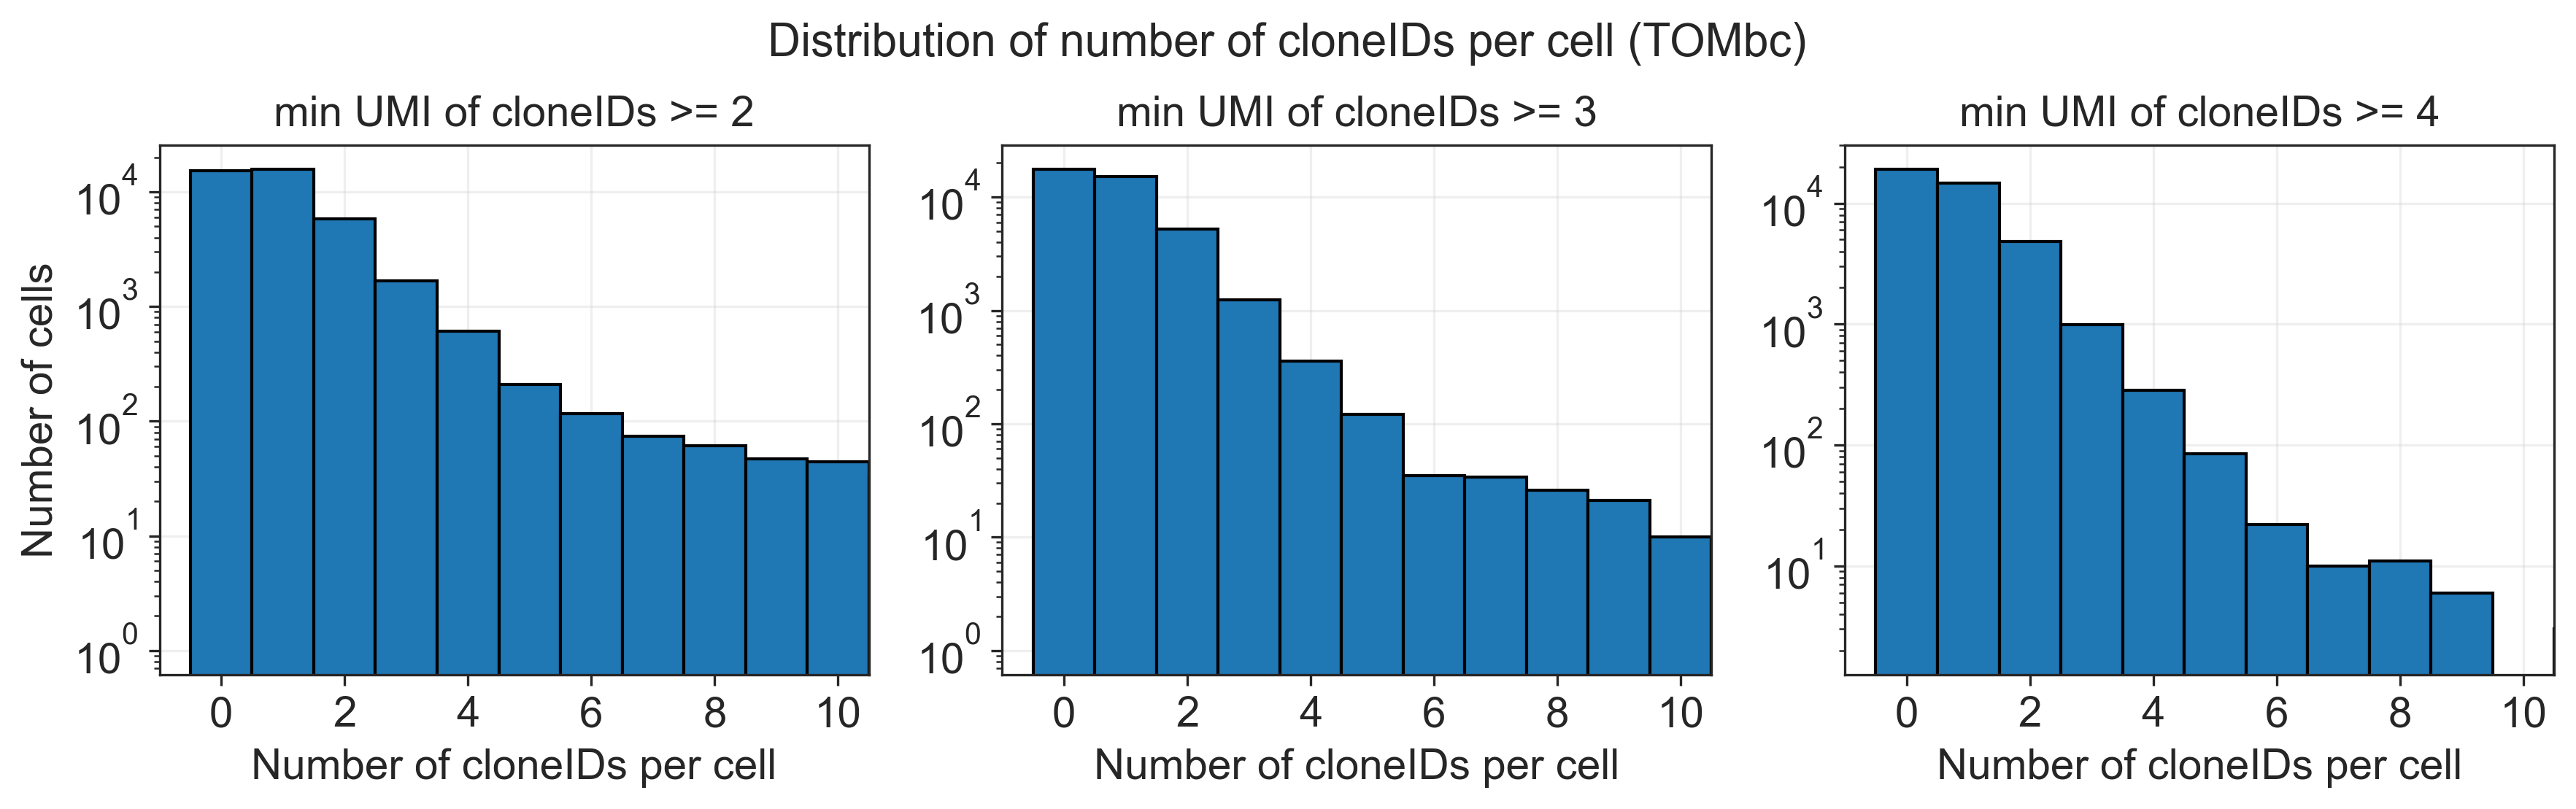

In [8]:
for FP in FPs:
    fig = draw_cloneID_QC(mdata[FP], FP)

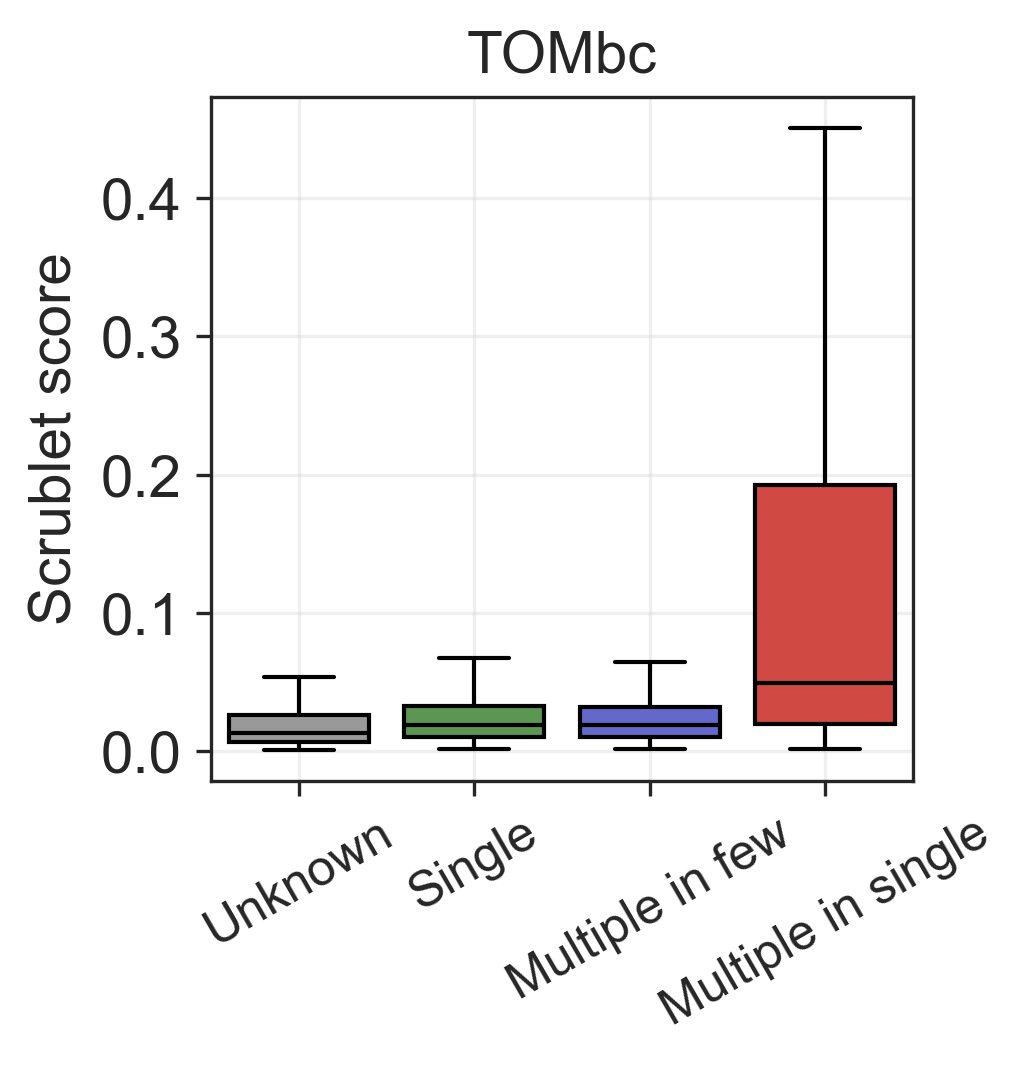

In [9]:
# Step 5: doublet detection via multiple clone ids per cell
min_cloneID_umi = 2
for FP in FPs:
    predict_doublets(mdata, FP, min_cloneID_umi=min_cloneID_umi)

    fig, ax = plt.subplots(figsize=(3, 3))
    order = ["Unknown", "Single", "Multiple in few", "Multiple in single"]
    sns.boxplot(x=mdata[FP].obs.clone_id_multiplet, y=mdata["GEX"].obs.doublet_score, order=order,
                showfliers=False, palette=colormap_boxplot_1, **black_borders_boxplot, linewidth=1)
    ax.tick_params(axis="x", labelrotation=30, labelsize=12)
    ax.set_ylabel("Scrublet score")
    ax.set_xlabel("")
    ax.grid(alpha=0.3)
    ax.set_title(FP)

In [10]:
if len(FPs) == 2:
    predict_doublets(mdata, FPs, min_cloneID_umi=min_cloneID_umi)

    fig, ax = plt.subplots(figsize=(3, 3))
    order = ["Unknown", "GFPbc", "TOMbc", "Multiple in few", "Multiple in single"]
    sns.boxplot(x=mdata.obs.clone_id_multiplet, y=mdata["GEX"].obs.doublet_score, order=order,
                showfliers=False, palette=colormap_boxplot_2, **black_borders_boxplot, linewidth=1)
    ax.tick_params(axis="x", labelrotation=30, labelsize=12)
    ax.set_ylabel("Scrublet score")
    ax.set_xlabel("")
    ax.grid(alpha=0.3)
    ax.set_title("Double injection")

In [11]:
mdata["GEX"].obs["predicted_doublet"] = (mdata["GEX"].obs.doublet_score > 0.15).astype(str)
print(f"Total num of cells: {len(mdata['GEX'])}")
if len(FPs) == 2:
    doublets = (
        (mdata["GEX"].obs.predicted_doublet == "True") |
        (mdata[FPs[0]].obs.clone_id_multiplet == "Multiple in single") |
        (mdata[FPs[1]].obs.clone_id_multiplet == "Multiple in single") |
        (mdata.obs.clone_id_multiplet == "Multiple in single")
    )
    print(f"Number of estimated doublets: {doublets.sum()} ({doublets.sum() / len(mdata['GEX']) * 100:.2f}%)")
else:
    doublets = (
        (mdata["GEX"].obs.predicted_doublet == "True") |
        (mdata[FPs[0]].obs.clone_id_multiplet == "Multiple in single")
    )
    print(f"Number of estimated doublets: {doublets.sum()} ({doublets.sum() / len(mdata['GEX']) * 100:.2f}%)")

Total num of cells: 40087
Number of estimated doublets: 6253 (15.60%)


In [12]:
# Step 6: filtering out doublets
mdata = mdata[~doublets]
del mdata["GEX"].obs["predicted_doublet"]

In [13]:
batch = list(set(mdata["GEX"].obs.batch))[0]
for FP in FPs:
    mdata["GEX"].obs[f"{time[FP]}:clones"] = fast_clones(mdata[FP], min_cloneID_umi=min_cloneID_umi)
    for clone in mdata["GEX"].obs[f"{time[FP]}:clones"].value_counts()[mdata["GEX"].obs[f"{time[FP]}:clones"].value_counts() == 1].index:
        mdata["GEX"].obs[f"{time[FP]}:clones"][mdata["GEX"].obs[f"{time[FP]}:clones"] == clone] == "Unknown"
    mdata["GEX"].obs[f"{time[FP]}:clones"] = [
        "NA" if i == "Unknown" else batch + ":" + i for i in mdata["GEX"].obs[f"{time[FP]}:clones"]
    ]
    mdata["GEX"].obs[f"{time[FP]}:clones"] = mdata["GEX"].obs[f"{time[FP]}:clones"].astype("category")

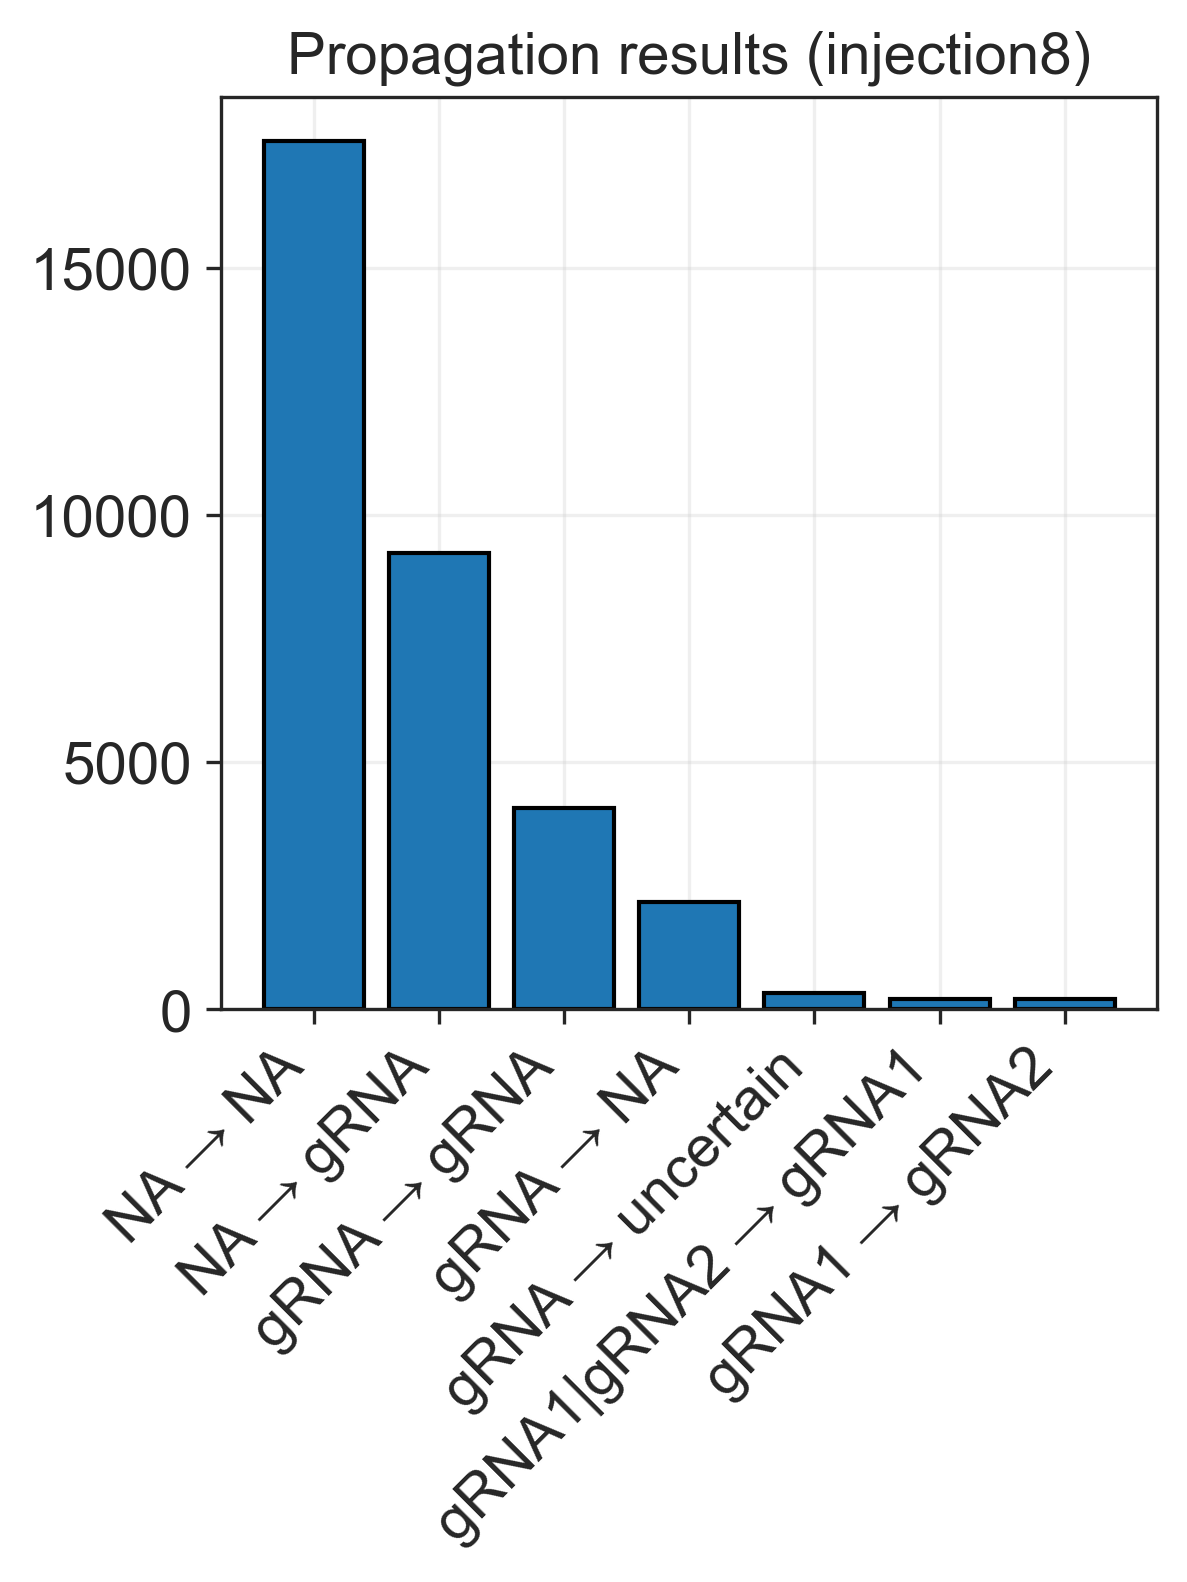

In [14]:
def transform_alphabetically(s):
    if "|" not in s:
        return s
    else:
        s = s.split("|")
        s.sort()
        return "|".join(s)
    
def gRNA_doublet(pred, obs):
    if len(pred) == 1:
        pred = set([pred])
    else:
        pred = set(pred.split("|"))
    if len(obs) == 1:
        obs = set([obs])
    else:
        obs = set(obs.split("|"))
    return pred.issubset(obs)
    
if "CRISPR:num_features" in mdata["GEX"].obs.columns:
    clone_gRNA = {"NA": "NA"}
    
    for clone in set(mdata["GEX"].obs[f"{CRISPR_clone}:clones"]):
        if clone != "NA":
            gRNAs = mdata["GEX"].obs["CRISPR:targets"][
                mdata["GEX"].obs[f"{CRISPR_clone}:clones"] == clone
            ].values.astype(str)
            gRNAs = pd.Series([transform_alphabetically(feature) for feature in gRNAs])
            gRNA_counts = gRNAs[gRNAs != "nan"].value_counts()
            if len(gRNA_counts) == 0:
                clone_gRNA[clone] = "NA"
            elif len(gRNA_counts) == 1:
                clone_gRNA[clone] = gRNA_counts.index[0]
            elif gRNA_counts[0] > gRNA_counts[1]:
                clone_gRNA[clone] = gRNA_counts.index[0]
            else:
                clone_gRNA[clone] = "uncertain"
            
    mdata["GEX"].obs["CRISPR:predicted"] = [
        clone_gRNA[clone] for clone in mdata["GEX"].obs[f"{CRISPR_clone}:clones"]
    ]
    
    na_pred = 0
    match = 0
    na_na = 0
    doublet = 0
    mismatch = 0
    uncertainty = 0
    obs_na = 0
    
    propagation = []
    
    for obs, pred in zip(
        mdata["GEX"].obs["CRISPR:targets"],
        mdata["GEX"].obs["CRISPR:predicted"],
    ):
        if (obs == "nan"):
            if (pred == "NA"):
                na_na += 1
                propagation.append("na_na")
            else:
                na_pred += 1
                propagation.append("na_pred")
        elif obs == pred:
            match += 1
            propagation.append("match")
        elif pred == "uncertain":
            uncertainty += 1
            propagation.append("uncertain")
        elif gRNA_doublet(pred, obs):
            doublet += 1
            propagation.append("doublet")
        elif pred == "NA":
            obs_na += 1
            propagation.append("non-clonal")
        else:
            mismatch += 1
            propagation.append("mismatch")
    
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

    plot = pd.Series([
        uncertainty, na_na, na_pred, mismatch, doublet, match, obs_na
    ], index=[
        "gRNA → uncertain", "NA → NA", "NA → gRNA",
        "gRNA1 → gRNA2", "gRNA1|gRNA2 → gRNA1", "gRNA → gRNA",
        "gRNA → NA",
    ])

    ax.bar(
        height=plot.sort_values(ascending=False),
        x=plot.sort_values(ascending=False).index,
        edgecolor="black",
    )
    ax.set_title(f"Propagation results ({batch})")
    plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
    ax.grid(alpha=0.3)

In [15]:
if "CRISPR:num_features" in mdata["GEX"].obs.columns:
    mdata["GEX"].obs["CRISPR:propagation_status"] = propagation
    mdata.update()

In [17]:
mdata.write_h5mu(f"{DATA_PATH}/anndatas_counts/{batch}.h5mu")
mdata["GEX"].write_h5ad(f"{DATA_PATH}/anndatas_counts/{batch}.h5ad")